# Spectral Analysis for paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
import swordfish as sf
from WIMpy import DMUtils as DMU
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from paleo.paleopy import *

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
%matplotlib inline

#### Load information for Sylvanite

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


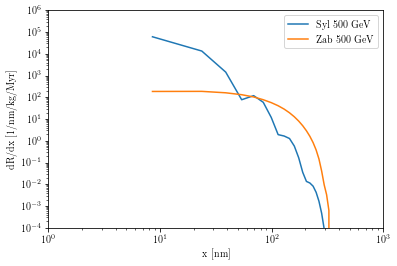

In [3]:
x_bins = np.linspace(1,1000,67)
x_width = np.diff(x_bins)
x_c = x_bins[:-1] + x_width/2
E_list = np.logspace(-1, 3, 500) # keV
nu_list = ['DSNB', 'atm', 'hep', '8B', '15O', '17F', '13N', 'pep']

Syl = dRdx(x_bins, 1e-45, 500, rock='Syl')
Zab = dRdx(x_bins, 1e-45, 500, rock='Zab')
plt.loglog(x_c, Syl, label='Syl 500 GeV')
plt.loglog(x_c, Zab, label='Zab 500 GeV')
plt.legend()
plt.ylabel("dR/dx [1/nm/kg/Myr]")
plt.xlabel("x [nm]")
plt.ylim(1e-4,1e6)
plt.xlim(1,1000)
plt.show()

#### Now we need to load the backgrounds

In [4]:
dRdx_Sylnu = dRdx_nu(x_bins, E_list, rock='Syl', components=True, gaussian=True)
dRdx_Zabnu = dRdx_nu(x_bins, E_list, rock='Zab', components=True, gaussian=True)

 DMutils.py: Loading neutrino flux for the first time...
Loading neutrino fluxes for...
    DSNB
    atm
    hep
    8B
    15O
    17F
    pep
    13N
...done.


#### Lets now load the fission backgrounds

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


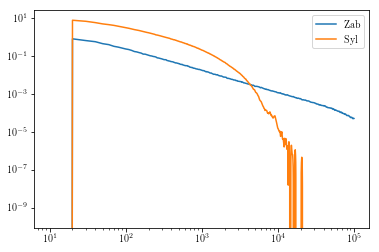

In [5]:
Syl_fiss_x, Syl_fiss_rate = np.loadtxt('../Data/Sylvanite_fission.dat', usecols=(0,1), unpack=True)
Zab_fiss_x, Zab_fiss_rate = np.loadtxt('../Data/Zabuyelite_fission.dat', usecols=(0,1), unpack=True)

Syl_fiss_x *= 10 # Converts angstrom to nm
Zab_fiss_x *= 10 # Converts angstrom to nm

Syl_fiss_rate /= 10 # Converts angstrom^-1 to nm^-1
Zab_fiss_rate /= 10 # Converts angstrom^-1 to nm^-1

plt.loglog(Zab_fiss_x, Zab_fiss_rate, label='Zab')
plt.loglog(Syl_fiss_x, Syl_fiss_rate, label='Syl')
plt.legend()
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


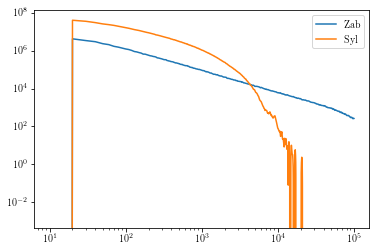

In [6]:
T_half_238 = 4.47e9
T_fission_238 = 8.4e15
A = 6.022140857e23
fission_norm =  lambda n238_permass, E: (n238_permass*(1-np.exp(-E*np.log(2)/T_half_238))
                             *(T_half_238/T_fission_238))

molmass = 100 # FIXME: change in the future to accurate numbers
n238_permass = lambda m: 1e-9*m*1e3*A/molmass

fis = fission_norm(n238_permass(1),1e7)

Zab_fiss_rate *= fis
Syl_fiss_rate *= fis

plt.loglog(Zab_fiss_x, Zab_fiss_rate, label='Zab')
plt.loglog(Syl_fiss_x, Syl_fiss_rate, label='Syl')
plt.legend()
plt.show()

In [7]:
bkgfis_Zab = interp1d(Zab_fiss_x, Zab_fiss_rate, bounds_error=False,
                                              fill_value='extrapolate')
bkgfis_Syl = interp1d(Syl_fiss_x, Syl_fiss_rate, bounds_error=False,
                                              fill_value='extrapolate')

dRdx_Sylnu.append(gaussian_filter1d(bkgfis_Syl(x_c)*x_width,1))
dRdx_Zabnu.append(gaussian_filter1d(bkgfis_Zab(x_c)*x_width,1))
nu_list.append('fission')

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


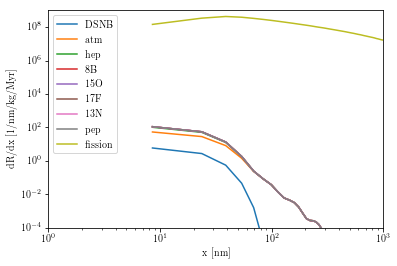

In [8]:
for i, nusource in enumerate(nu_list):
    plt.loglog(x_c, dRdx_Sylnu[i], label=nusource)
#     plt.loglog(x_c,dRdx_Sylnu_gauss[i], label=nusource, ls='--')

# plt.loglog(x_c,dRdx_Sylnu[0], 'C0', label='test')
# plt.loglog(x_c,dRdx_Sylnu_gauss[0], 'C0', label='test', ls='--')
    
# plt.loglog(x_c, dRdx_Sylnu_all, label='Total')
plt.legend()
plt.ylabel("dR/dx [1/nm/kg/Myr]")
plt.xlabel("x [nm]")
plt.ylim(1e-4,1e9)
plt.xlim(1,1000)
plt.show()

In [11]:
ref_sig = 1e-47
systematics = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.01]
mlist = np.logspace(-0.5,4,num=100)
Syl_limit = np.zeros_like(mlist)
Syl_DR = np.zeros_like(mlist)

for i, m in enumerate(mlist):
    SF = sf.Swordfish(dRdx_Sylnu, T=systematics, E=np.ones_like(dRdx_Sylnu[0])*10)
    sig = gaussian_filter1d(dRdx(x_bins, ref_sig, m, rock='Syl'),1)+1e-20
    UL = SF.upperlimit(sig, 0.05)
    DR = SF.discoveryreach(sig, 2.87e-7)
    Syl_limit[i] = ref_sig * UL
    Syl_DR[i] = ref_sig * DR
    
np.savetxt('Sylvanite_lims.txt', list(zip(mlist, Syl_limit)))

In [12]:
ref_sig = 1e-47
systematics = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.01]
Zab_limit = np.zeros_like(mlist)
Zab_DR = np.zeros_like(mlist)

for i, m in enumerate(mlist):
    SF = sf.Swordfish(dRdx_Zabnu, T=systematics, E=np.ones_like(dRdx_Zabnu[0])*10)
    sig = gaussian_filter1d(dRdx(x_bins, ref_sig, m, rock='Zab'),1)+1e-20
    UL = SF.upperlimit(sig, 0.05)
    DR = SF.discoveryreach(sig, 2.87e-7)
    Zab_limit[i] = ref_sig * UL
    Zab_DR[i] = ref_sig * DR
    
np.savetxt('Zabuyelite_lims.txt', list(zip(mlist, Zab_limit)))

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


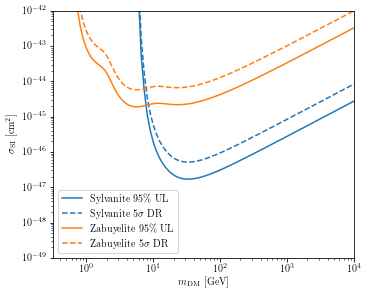

In [13]:
plt.figure(figsize=(5,4))
plt.loglog(mlist,Syl_limit, color='C0', linestyle='-', label=r'Sylvanite 95\% UL')
plt.loglog(mlist,Syl_DR, color='C0', linestyle='--', label=r'Sylvanite $5\sigma$ DR')
plt.loglog(mlist,Zab_limit, color='C1', linestyle='-', label=r'Zabuyelite 95\% UL')
plt.loglog(mlist,Zab_DR, color='C1', linestyle='--', label=r'Zabuyelite $5\sigma$ DR')
plt.ylabel(r'$\sigma_{\mathrm{SI}} ~[\mathrm{cm}^2]$')
plt.xlabel(r'$m_{\mathrm{DM}} ~[\mathrm{GeV}]$')
plt.xlim(10**(-0.5),1e4)
plt.ylim(1e-49,1e-42)
plt.legend()
plt.tight_layout(pad=0.3)
# plt.show()
plt.savefig("../plots/limits_nubkg_separate-10psys.pdf")